In [21]:
import pandas as pd
from pandas_analysis import create_method_analysis
from methods_from_spark import z_score_anomalies, iqr_anomalies, iforest_anomalies, arima_anomalies

Mean batch size: 18.76210979547901
Batch size STD: 60.9111884068122
Batch size Median: 3.0


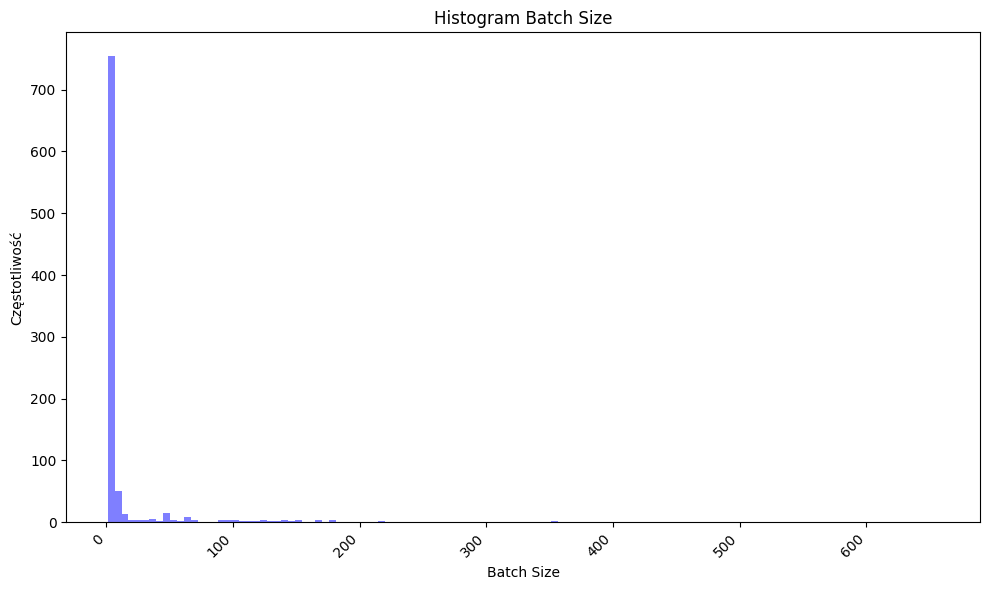

Number of batches: 52, batch size: 18
Confusion Matrix for Price Anomalies:
[[911   7]
 [ 11   0]]

Confusion Matrix for Volume Anomalies:
[[795  12]
 [102  20]]


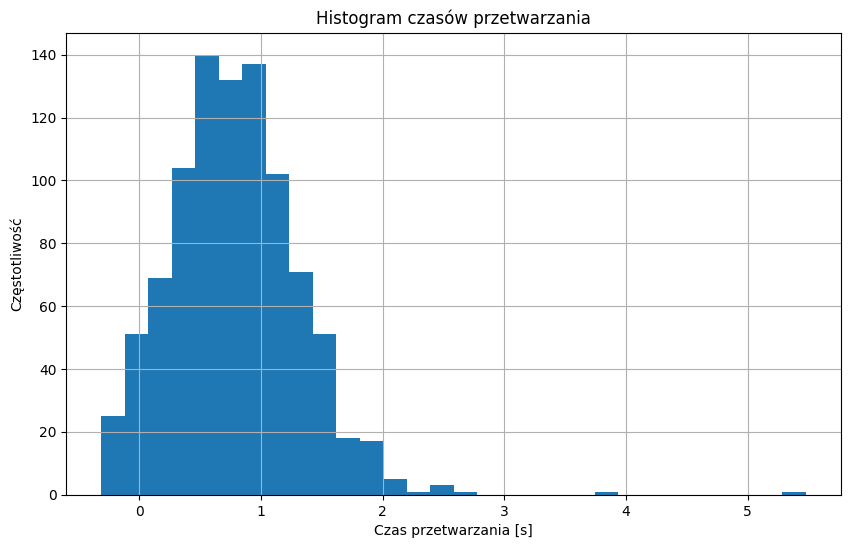

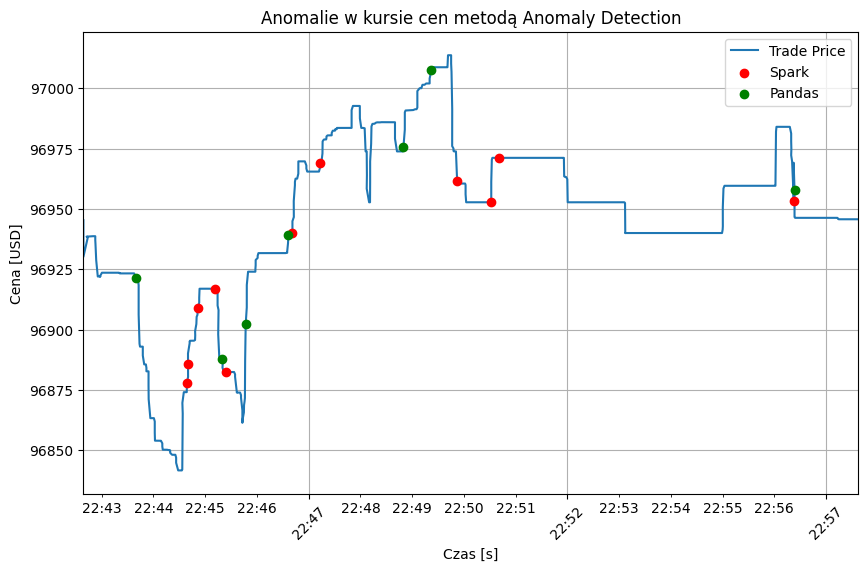

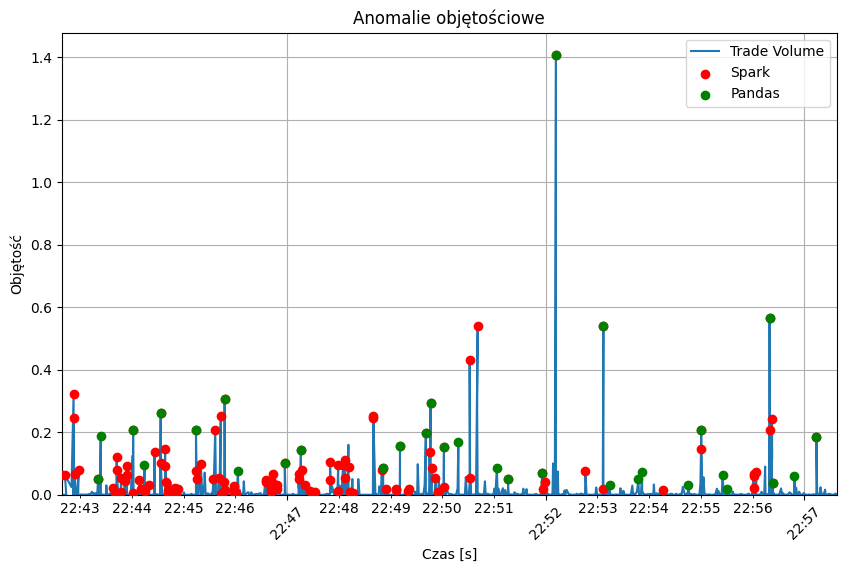

In [22]:
df = pd.read_csv('data/z-score/combined_15min.csv')
create_method_analysis(z_score_anomalies, df)

Mean batch size: 18.26074074074074
Batch size STD: 52.236420265170736
Batch size Median: 3.0


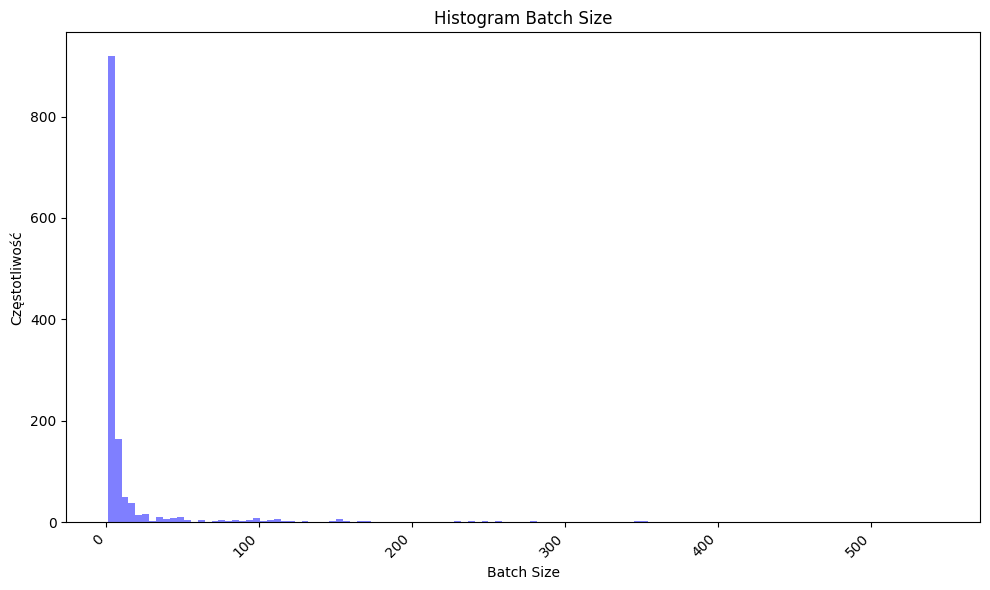

Number of batches: 75, batch size: 18
Confusion Matrix for Price Anomalies:
[[1110   70]
 [ 161    9]]

Confusion Matrix for Volume Anomalies:
[[938  83]
 [250  79]]


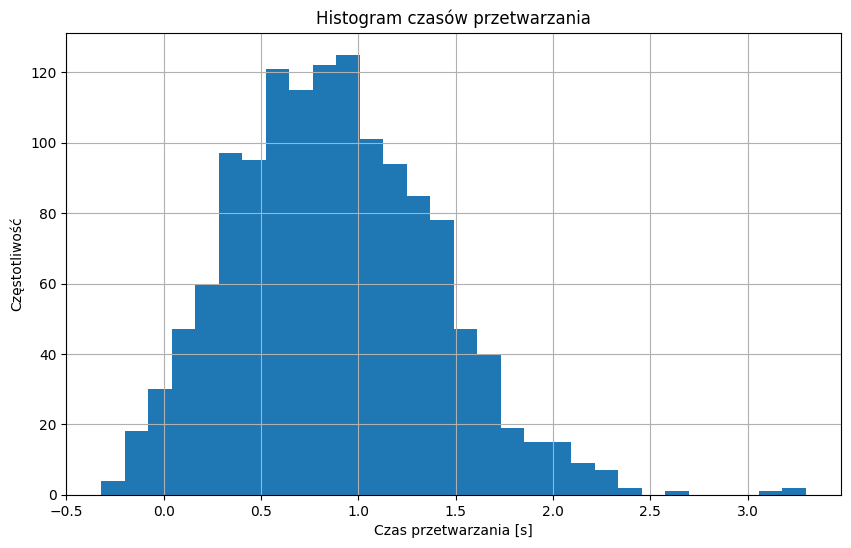

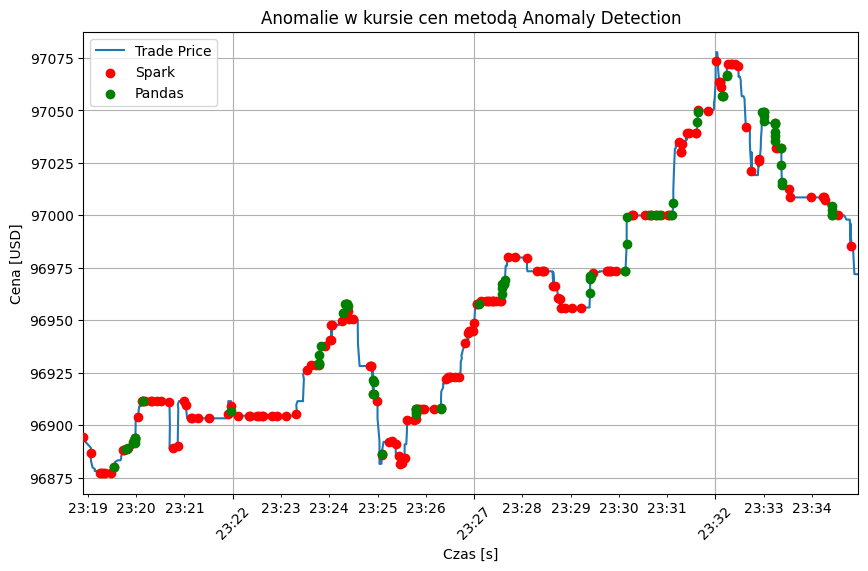

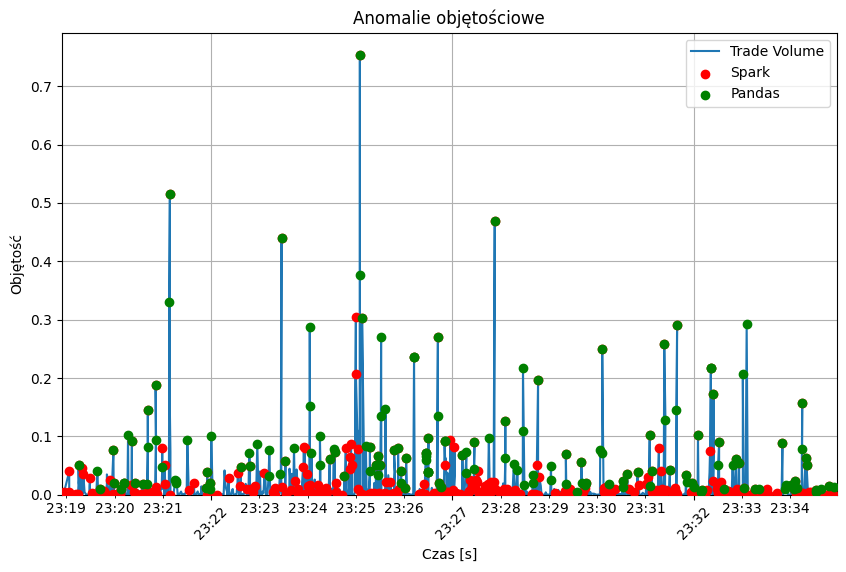

In [23]:
df = pd.read_csv('data/iqr/combined_15min.csv')
create_method_analysis(iqr_anomalies, df)

Mean batch size: 17.788910505836576
Batch size STD: 57.468040257195945
Batch size Median: 3.0


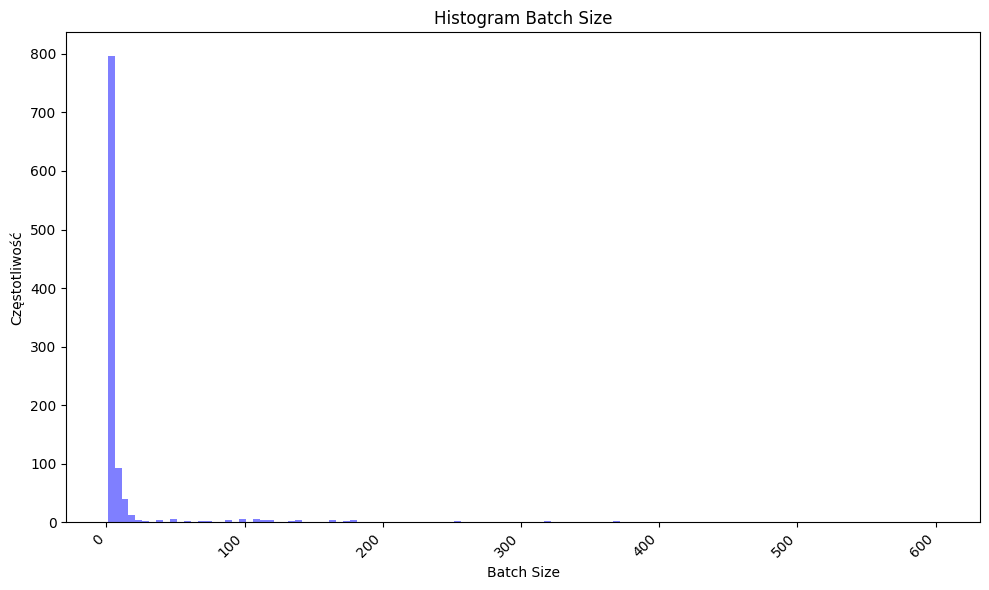

Number of batches: 61, batch size: 17


C:\Users\seksc\Documents\sem7\anomaly-detection\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\seksc\Documents\sem7\anomaly-detection\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\seksc\Documents\sem7\anomaly-detection\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\seksc\Documents\sem7\anomaly-detection\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as sta

Confusion Matrix for Price Anomalies:
[[812  55]
 [156   5]]

Confusion Matrix for Volume Anomalies:
[[902  14]
 [ 95  17]]


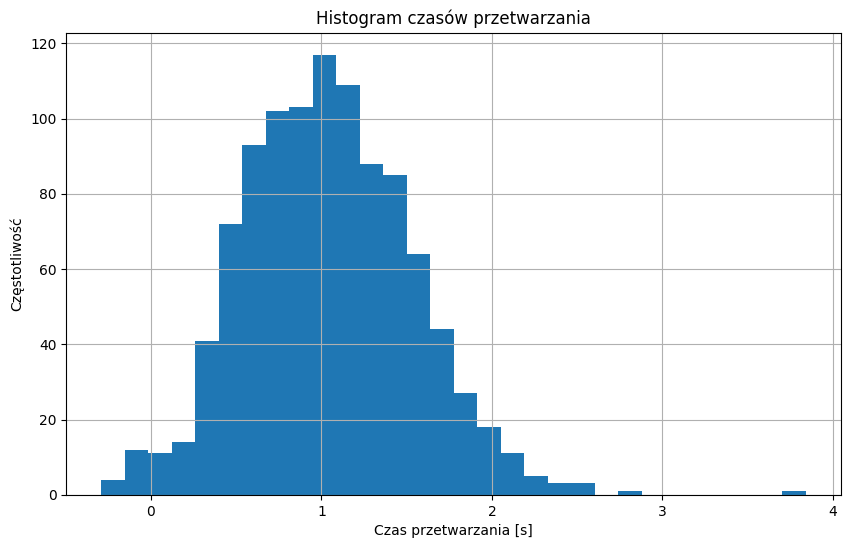

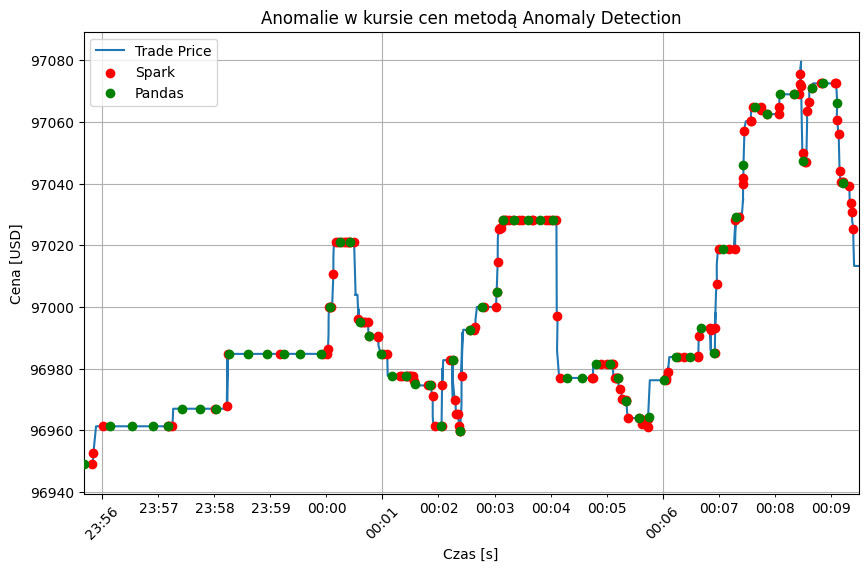

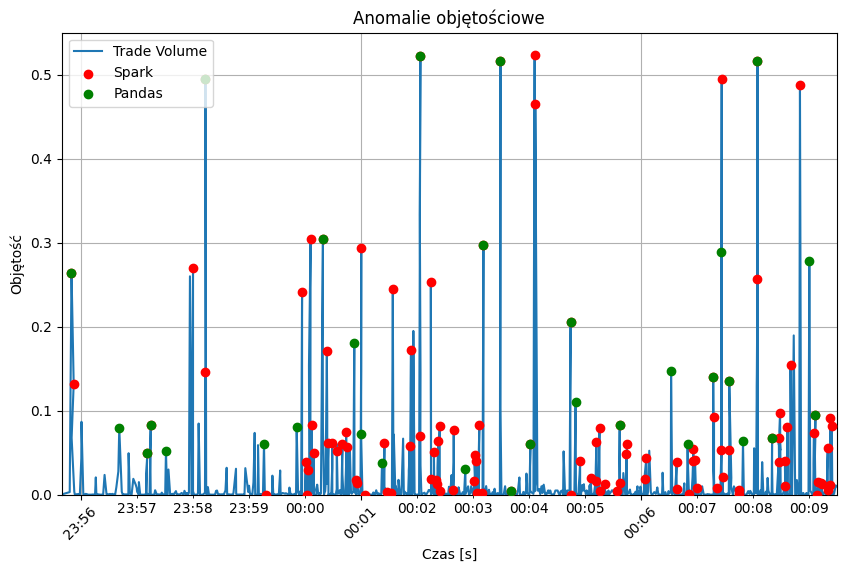

In [24]:
df = pd.read_csv('data/arima/combined_15min.csv')
create_method_analysis(arima_anomalies, df)

Mean batch size: 12.75257731958763
Batch size STD: 45.49355041042355
Batch size Median: 2.0


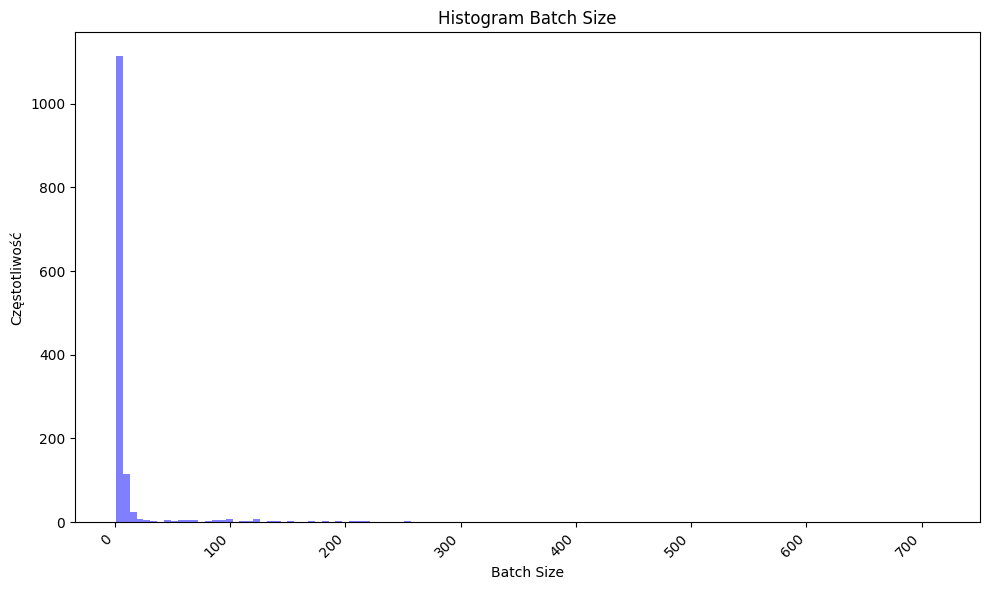

Number of batches: 114, batch size: 12


ValueError: cannot convert float NaN to integer

In [25]:
df = pd.read_csv('data/iforest/combined_15min.csv')
create_method_analysis(iforest_anomalies, df)